In [1]:
using FEFMM
using Interpolations
using Plots

In [2]:
Pkg.add(url="https://github.com/SFJucelino/FEFMM.jl.git", rev ="return_gradient")

LoadError: UndefVarError: Pkg not defined

In [3]:
using FEFMM
include("SolveEikonalEquation.jl")

Main.EikonalSolver

In [4]:
function PlotVectorField(mux, muy)
    meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
    
    ny, nx = size(mux)
    xs, ys = meshgrid(0.5:1:nx, 0.5:1:ny)
    u = reshape(transpose(mux), nx*ny, 1) .*0.8
    v = reshape(transpose(muy), nx*ny, 1) .*0.8
    quiver(ys,xs, quiver=(u,v))
end

PlotVectorField (generic function with 1 method)

In [83]:
function CalculateMU(Q, xRightRoom, xMiddleRoom, yDoorMin, yDoorMax)
    nx, ny = size(Q)
    mu_x = zeros(nx, ny)
    mu_y = zeros(nx, ny)
    xMiddleRoomEnd = xRightRoom - 1
    xLeftRoomEnd = xMiddleRoom - 1
    
    #Calculate mu for left Room
    itp = interpolate(Q[1:xLeftRoomEnd,1:ny], BSpline(Linear()))
    for x in 1:xLeftRoomEnd
        for y in 1:ny
            mu_x[x,y], mu_y[x,y] = Interpolations.gradient(itp, x, y)
        end
    end
    
    #Calculate mu for middle Room
    itp = interpolate(Q[xMiddleRoom:xMiddleRoomEnd,1:ny], BSpline(Linear()))
    for x in xMiddleRoom:xMiddleRoomEnd
        for y in 1:ny
            mu_x[x,y], mu_y[x,y] = Interpolations.gradient(itp, x - xLeftRoomEnd, y)
        end
    end
    
    #Calculate mu for right Room
    itp = interpolate(Q[xRightRoom:nx,1:ny], BSpline(Linear()))
    for x in xRightRoom:nx
        for y in 1:ny
            mu_x[x,y], mu_y[x,y] = Interpolations.gradient(itp, x - xMiddleRoomEnd, y)
        end
    end
    
    #Hardcode boundary condition
#    for index in findall(i -> (i<0), mu_x[xLeftRoomEnd, 1 : yDoorMin - 1])
#        mu_x[xLeftRoomEnd, index] = 0
#        mu_x[xMiddleRoomEnd, index] = 0
#    end

#    for index in findall(i -> (i<0), mu_x[xLeftRoomEnd, yDoorMax + 1 : ny])
#        mu_x[xLeftRoomEnd, index + yDoorMax] = 0
#        mu_x[xMiddleRoomEnd, index + yDoorMax] = 0
#    end
    
    #normalize mu
    norm = (mu_x.^2 + mu_y.^2).^0.5 .*-1.0
    mu_x = mu_x ./ norm
    mu_y = mu_y ./ norm
    return mu_x, mu_y
end

CalculateMU (generic function with 1 method)

In [107]:
function FFMRight(rho1, rho2, mu1_x, mu1_y, mu2_x, mu2_y, f1, dx, CalculateMU)

    # Define kost function
    k2 = map(f1, transpose(rho1), transpose(rho2), transpose(mu1_x), transpose(mu1_y), transpose(mu2_x), transpose(mu2_y))

    # Construct view in Omega1
    partial_view = k2[1:20,26:30]

    # Initialize arrays
    Q1 = ones(size(partial_view))*typemax(Float64)
    #mu_x1 = zeros(size(partial_view))
    #mu_y1 = zeros(size(partial_view))

    # minimize Q and update gradient in view
    for i = 1:20
        targetCell = CartesianIndex(i,5)
        temp, grad = fefmm_grad(partial_view,dx, targetCell)
        temp = temp .+ partial_view[targetCell] * dx[2] / 2.0
        for index in findall(i->(i > 0),Q1-temp)
            Q1[index] = temp[index]
            #mu_x1[index] = grad[2][index]
            #mu_y1[index] = grad[1][index]
        end
    end

    # Construct view near door1
    partial_view = k2[8:12, 25:26]
    outflow = Q1[8:12, 1]

    # Initialize arrays
    Q2 = ones(size(partial_view))*typemax(Float64)
    #mu_x2 = zeros(size(partial_view))
    #mu_y2 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(i,2))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q2-temp)
            Q2[index] = temp[index]
            #mu_x2[index] = grad[2][index]
            #mu_y2[index] = grad[1][index]
        end
    end

    # Construct view in Omega2
    partial_view = k2[1:20, 5:25]
    outflow = Q2[1:5, 1]

    # Initialize arrays
    Q3 = ones(size(partial_view))*typemax(Float64)
    #mu_x3 = zeros(size(partial_view))
    #mu_y3 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(7 + i, 20))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q3-temp)
            Q3[index] = temp[index]
            #mu_x3[index] = grad[2][index]
            #mu_y3[index] = grad[1][index]
        end
    end
    
    # Construct view near door2
    partial_view = k2[8:12, 4:5]
    outflow = Q3[8:12, 1]

    # Initialize arrays
    Q4 = ones(size(partial_view))*typemax(Float64)
    #mu_x4 = zeros(size(partial_view))
    #mu_y4 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(i,2))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q4-temp)
            Q4[index] = temp[index]
            #mu_x4[index] = grad[2][index]
            #mu_y4[index] = grad[1][index]
        end
    end
    
    # Construct view in Omega3
    partial_view = k2[1:20, 1:4]
    outflow = Q4[1:5, 1]

    # Initialize arrays
    Q5 = ones(size(partial_view))*typemax(Float64)
    #mu_x5 = zeros(size(partial_view))
    #mu_y5 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(7 + i, 4))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q5-temp)
            Q5[index] = temp[index]
            #mu_x5[index] = grad[2][index]
            #mu_y5[index] = grad[1][index]
        end
    end

    # Combine gradients
    #mu1_x = -1.0*ones(100, 100)
    #mu1_x[1:100, 1:19] = mu_x5
    #mu1_x[1:100, 20:80] = mu_x3
    #mu1_x[1:100, 81:99] = mu_x1[1:100, 1:19]
    #mu1_x[45:55, 19:20] = mu_x4
    #mu1_x[45:55, 80:81] = mu_x2

    #mu1_y = zeros(100, 100)
    #mu1_y[1:100, 1:19] = mu_y5
    #mu1_y[1:100, 20:80] = mu_y3
    #mu1_y[1:100, 81:99] = mu_y1[1:100, 1:19]
    #mu1_y[45:55, 19:20] = mu_y4
    #mu1_y[45:55, 80:81] = mu_y2

    #norm = (mu1_x.^2 + mu1_y.^2).^0.5
    #mu1_x = transpose(mu1_x ./ norm .* -1.0)
    #mu1_y = transpose(mu1_y ./ norm .* -1.0)
    
    # Combine distance
    Q = zeros(20, 30)
    Q[1:20, 1:4] = Q5
    Q[1:20, 5:25] = Q3
    Q[1:20, 26:30] = Q1
    Q[8:12, 4:5] = Q4
    Q[8:12, 25:26] = Q2
    Q = transpose(Q)
    
    mu1_x, mu1_y = CalculateMU(Q, 25, 6, 8, 12)

    return Q, mu1_x, mu1_y
end

FFMRight (generic function with 1 method)

In [108]:
function FFMLeft(rho1, rho2, mu1_x, mu1_y, mu2_x, mu2_y, f2, dx, CalculateMU)

    # Define kost function
    k2 = map(f2, transpose(rho1), transpose(rho2), transpose(mu1_x), transpose(mu1_y), transpose(mu2_x), transpose(mu2_y))

    # Construct view in Omega1
    partial_view = k2[1:20,1:4]

    # Initialize arrays
    Q1 = ones(size(partial_view))*typemax(Float64)
    #mu_x1 = zeros(size(partial_view))
    #mu_y1 = zeros(size(partial_view))

    # minimize Q and update gradient in view
    for i = 1:20
        targetCell = CartesianIndex(i,1)
        temp, grad = fefmm_grad(partial_view,dx, targetCell)
        temp = temp .+ partial_view[targetCell] * dx[2] / 2.0
        for index in findall(i->(i > 0),Q1-temp)
            Q1[index] = temp[index]
            #mu_x1[index] = grad[2][index]
            #mu_y1[index] = grad[1][index]
        end
    end

    # Construct view near door1
    partial_view = k2[8:12, 4:5]
    outflow = Q1[8:12, 4]

    # Initialize arrays
    Q2 = ones(size(partial_view))*typemax(Float64)
    #mu_x2 = zeros(size(partial_view))
    #mu_y2 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(i,1))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q2-temp)
            Q2[index] = temp[index]
            #mu_x2[index] = grad[2][index]
            #mu_y2[index] = grad[1][index]
        end
    end

    # Construct view in Omega2
    partial_view = k2[1:20, 5:25]
    outflow = Q2[1:5, 2]

    # Initialize arrays
    Q3 = ones(size(partial_view))*typemax(Float64)
    #mu_x3 = zeros(size(partial_view))
    #mu_y3 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(7 + i, 1))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q3-temp)
            Q3[index] = temp[index]
            #mu_x3[index] = grad[2][index]
            #mu_y3[index] = grad[1][index]
        end
    end
    
    # Construct view near door2
    partial_view = k2[8:12, 25:26]
    outflow = Q3[8:12, 20]

    # Initialize arrays
    Q4 = ones(size(partial_view))*typemax(Float64)
    #mu_x4 = zeros(size(partial_view))
    #mu_y4 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(i,1))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q4-temp)
            Q4[index] = temp[index]
            #mu_x4[index] = grad[2][index]
            #mu_y4[index] = grad[1][index]
        end
    end
    
    # Construct view in Omega3
    partial_view = k2[1:20, 26:30]
    outflow = Q4[1:5, 2]

    # Initialize arrays
    Q5 = ones(size(partial_view))*typemax(Float64)
    #mu_x5 = zeros(size(partial_view))
    #mu_y5 = zeros(size(partial_view))

    for i = 1:5
        temp, grad = fefmm_grad(partial_view,dx, CartesianIndex(7 + i, 1))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q5-temp)
            Q5[index] = temp[index]
            #mu_x5[index] = grad[2][index]
            #mu_y5[index] = grad[1][index]
        end
    end

    # Combine gradients
    #mu2_x = ones(100, 100)
    #mu2_x[1:100, 2:19] = mu_x1[1:100, 2:19]
    #mu2_x[1:100, 20:80] = mu_x3
    #mu2_x[1:100, 81:100] = mu_x5
    #mu2_x[45:55, 19:20] = mu_x2
    #mu2_x[45:55, 80:81] = mu_x4

    #mu2_y = zeros(100, 100)
    #mu2_y[1:100, 2:19] = mu_y1[1:100, 2:19]
    #mu2_y[1:100, 20:80] = mu_y3
    #mu2_y[1:100, 81:100] = mu_y5
    #mu2_y[45:55, 19:20] = mu_y2
    #mu2_y[45:55, 80:81] = mu_y4

    norm = (mu2_x.^2 + mu2_y.^2).^0.5
    #mu2_x = transpose(mu2_x ./ norm .* -1.0)
    #mu2_y = transpose(mu2_y ./ norm .* -1.0)
    
    # Combine distance
    Q = zeros(20, 30)
    Q[1:20, 1:4] = Q1
    Q[1:20, 5:25] = Q3
    Q[1:20, 26:30] = Q5
    Q[8:12, 4:5] = Q2
    Q[8:12, 25:26] = Q4
    Q = transpose(Q)
    
    mu2_x, mu2_y = CalculateMU(Q, 25, 6, 8, 12)

    return Q, mu2_x, mu2_y
end

FFMLeft (generic function with 1 method)

In [151]:
V(rho) = 1.0-rho
f(rho1, rho2, mu1x, mu1y, mu2x, mu2y) = 1.0/V(rho1+rho2)
f1(rho1, rho2, mu1x, mu1y, mu2x, mu2y) = (1.0+0.7*rho2)/(V(rho1+rho2)*(1.0+0.7*rho2*(mu1x*mu2x+mu1y*mu2y)))
f2(rho1, rho2, mu1x, mu1y, mu2x, mu2y) = (1.0+0.7*rho1)/(V(rho1+rho2)*(1.0+0.7*rho1*(mu1x*mu2x+mu1y*mu2y)))

dx = [1.0, 1.0]
rho1 = ones(20,30)*0
rho1[1:10, 5:25] = ones(10,21)*0.9
rho2 = ones(20,30)*0
rho2[11:20, 5:25] = ones(10,21)*0.9
rho1 = transpose(rho1)
rho2 = transpose(rho2)

30×20 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.0  0.

In [152]:
tol = 0.01
maxIter = 1000

error = Inf
iter = 0
mux1, muy1, mux2, muy2 = zeros(size(rho1)), zeros(size(rho1)), zeros(size(rho1)), zeros(size(rho1))
phi1, mux1, muy1 = FFMRight(rho1, rho2, mux1, muy1, mux2, muy2, f, dx, CalculateMU)
phi2, mux2, muy2 = FFMLeft(rho1, rho2, mux1, muy1, mux2, muy2, f, dx, CalculateMU)
while error > tol && iter < maxIter
    phi1old = deepcopy(phi1)
    phi2old = deepcopy(phi2)
    mux1old = deepcopy(mux1)
    muy1old = deepcopy(muy1)
    mux2old = deepcopy(mux2)
    muy2old = deepcopy(muy2)
    global phi1, mux1, muy1 = FFMRight(rho1, rho2, mux1old, muy1old, mux2old, muy2old, f1, dx, CalculateMU)
    global phi2, mux2, muy2 = FFMLeft(rho1, rho2, mux1old, muy1old, mux2old, muy2old, f2, dx, CalculateMU)
    global error = max(maximum(abs.(phi1old[5:25, 1:20] - phi1[5:25, 1:20])./phi1[5:25, 1:20]), maximum(abs.(phi2old[5:25, 1:20] - phi2[5:25, 1:20])./phi2[5:25, 1:20]))
    global iter = iter + 1
    println(error)
end
iter


0.4687808483417481
0.1689267286002935
0.1562454080225396
0.08938384343924248
0.06740077890353208
0.058631644007029186
0.03528692221278494
0.034074513931084134
0.019617483592677662
0.015755233501394086
0.008629689817582458


11

In [32]:
using Plots

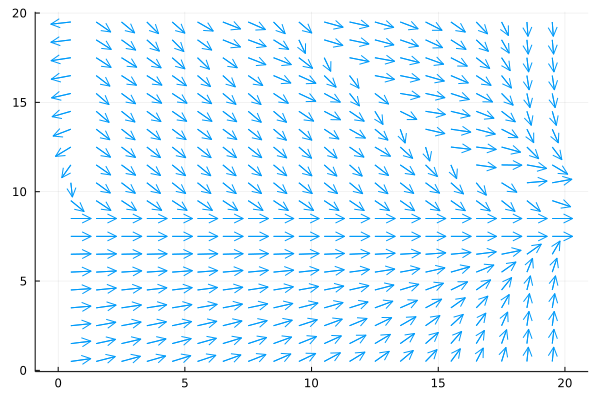

In [153]:
PlotVectorField(mux1[5:24, 1:20], muy1[5:24, 1:20])